### Parse predictions for panproteins from DeepTMHMM, SignalP, and PSORTb

In [1]:
import pandas as pd

from Bio import SeqIO
from pyteomics import mass, parser, electrochem
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
def update_relationship_phrase(row, biosequence_to_relationship_phrase):
    if row["relationship_phrase"] == "identical":
        # return the relationship phrase of the protein it is identical to (=> the reference biosequence)
        identical_to = row["reference_biosequence"]
        return biosequence_to_relationship_phrase[identical_to]
    return row["relationship_phrase"]


def parse_IDs(files):
    """
    Parse protein IDs from files and return a dictionary with tier names as keys and DataFrames as values.
    """
    IDs = {}

    for file in files:
        name = file.name
        name = name.replace(".tsv", "").replace("PA2_", "")
        IDs[name] = pd.read_table(file)
        # filter out phages
        IDs[name] = IDs[name][~IDs[name]["biosequence_name"].str.contains("PHAGE_sp")]

        # update relationship phrase for proteins that are identical to an indistinguishable protein, not an identical one
        biosequence_to_relationship_phrase = {row["biosequence_name"]: row["relationship_phrase"] for index, row in IDs[name].iterrows()}
        IDs[name]["relationship_phrase"] = IDs[name].apply(lambda row: update_relationship_phrase(row, biosequence_to_relationship_phrase), axis=1)


    # combine uncertain tiers into one
    IDs["uncertain"] = pd.concat([IDs["weak"], IDs["insufficient_evidence"], IDs["subsumed"], IDs["indistinguishable_representative"]])
    del IDs["insufficient_evidence"]
    del IDs["subsumed"]
    del IDs["indistinguishable_representative"]

    # combine canonical and noncore canonical
    IDs["canonical"] = pd.concat([IDs["canonical"], IDs["noncore_canonical"]])

    # remove indistinguishables from canonical and add them to own tier
    IDs["indistinguishable_from_canonical"] = IDs["canonical"][IDs["canonical"]["relationship_phrase"] == "indistinguishable"]
    IDs["canonical"] = IDs["canonical"][IDs["canonical"]["relationship_phrase"] != "indistinguishable"]

    # remove indistinguishables from uncertain and add them to uncertain tier
    IDs["uncertain"] = pd.concat([IDs["uncertain"], IDs["marginally_distinguished"][IDs["marginally_distinguished"]["relationship_phrase"] == "indistinguishable"]])
    IDs["marginally_distinguished"] = IDs["marginally_distinguished"][IDs["marginally_distinguished"]["relationship_phrase"] != "indistinguishable"]

    del IDs["all_tiers"]
    del IDs["noncore_canonical"]

    biosequence_to_evidence_level = {}
    for key in IDs:
        for index, row in IDs[key].iterrows():
            biosequence_to_evidence_level[row["biosequence_name"]] = key

    # read in fasta
    fasta = SeqIO.parse("../data/Fig4_properties_observed_notobserved/Ecoli_merged_nodup_contam_phage_2024-05_cleanacc_targetdecoy.fasta", "fasta")
    # remove decoys
    fasta = [record for record in fasta if "DECOY" not in record.id]
    # create a dictionary with the protein sequence
    protein_sequence_dict = {record.description: str(record.seq) for record in fasta}

    return protein_sequence_dict, biosequence_to_evidence_level


# read in evidence levels from PA
protein_id_folder = "../data/Fig1_Strain_proteome_coverage/per_evidence_level"
files = Path(protein_id_folder).glob("*.tsv")

protein_sequence_dict, biosequence_to_evidence_level = parse_IDs(files)



In [ ]:
# functions for calculating additional properties

def count_detectable_tryptic_peptides(sequence):
    sequence = sequence.replace("X", "")
    tryptic_peptides = parser.cleave(sequence, parser.expasy_rules["trypsin"], missed_cleavages=2)
    detectable_peptides = [peptide for peptide in tryptic_peptides if 6 <= len(peptide) <= 30 and 600 <= mass.calculate_mass(sequence=peptide) <= 4000]
    return len(detectable_peptides)

def calculate_isoelectric_point(sequence):
    sequence = sequence.replace("X", "")
    return electrochem.pI(sequence)

def calculate_gravy(sequence):
    sequence = sequence.replace("X", "")
    sequence = sequence.replace("U", "")
    return electrochem.gravy(sequence)

def get_evidence_level(biosequence_name):
    if "|" in biosequence_name:
        biosequence_name = biosequence_name.split("|")[1]
    try:
        return biosequence_to_evidence_level[biosequence_name]
    except KeyError:
        return "not observed"

def get_protein_sequence(accession):

    if "|" in accession:
        accession = accession.split("|")[1]

    for protein, sequence in protein_sequence_dict.items():
        if accession in protein:
            return sequence

    print(f"No protein sequence found for {accession}")
    return

def parse_clstr_file(filename):
    cluster_dict = {}
    current_cluster = None  # Variable to keep track of the current cluster being processed

    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('>Cluster'):
                current_cluster = line.strip().split(' ')[1]  # Extract the cluster number
            else:
                if "sp|P0DPN7|YMDG_ECOLI" in line:
                    print(line)
                # Extract the protein ID from the line
                if ">ST" in line:
                    # e.g. >ST73_ECFI4_00021... at 100.00%
                    protein_id = "_".join(line.split('_')[1:3]).split('...')[0]
                elif "|" in line:
                    # e.g. >APEC_sp|A1A7A0|RSMA_ECOK1_00001... at 0.000
                    # or >K12_sp|P0CE51|INSH3_ECOLI
                    # remove part before first _
                    protein_id = line.split('_', 1)[1].split("...")[0]
                else:
                    # e.g. >ATCC25922_UPI00001363DE... at 0.000
                    protein_id = line.split('_')[1].split('...')[0]

                if "sp|P0DPN7|YMDG_ECOLI" in line:
                    print(protein_id)

                # set the strain to 1 in df
                cluster_dict[protein_id] = current_cluster

    return cluster_dict

In [ ]:
predictions = pd.read_csv("../data/Fig4/cellular_localization_predictions.csv")

# add protein length, protein weight in Dalton, number of tryptic peptides, and isoelectric point
predictions["protein_sequence"] = predictions["Protein"].apply(get_protein_sequence)

# same protein sequence -> same properties
predictions = predictions.drop_duplicates(subset=["protein_sequence"])

predictions["protein_length"] = predictions["protein_sequence"].str.len()
predictions["protein_weight"] = predictions["protein_sequence"].apply(lambda x: mass.calculate_mass(sequence=x.replace("X", "")))

# add number of detectable tryptic peptides (6-30 amino acids, 600-4000 Da)
predictions["detectable_tryptic_peptides"] = predictions["protein_sequence"].apply(count_detectable_tryptic_peptides)
# add isoelectric point
predictions["isoelectric_point"] = predictions["protein_sequence"].apply(calculate_isoelectric_point)
# add gravy index
predictions["gravy"] = predictions["protein_sequence"].apply(calculate_gravy)
# add observation status from PeptideAtlas
predictions["evidence_level"] = predictions["Protein"].apply(lambda x: get_evidence_level(x))
predictions["observed"] = predictions["evidence_level"] != "not observed"

predictions

,Protein,SignalP_Prediction,Strain,PSORTb_Prediction,DeepTMHMM_Prediction
0,ECFI20_00002,OTHER,WGS_ST131,Unknown,GLOB
1,ECFI20_00003,OTHER,WGS_ST131,Cytoplasmic,GLOB
2,ECFI20_00004,OTHER,WGS_ST131,Cytoplasmic,GLOB
3,ECFI20_00005,OTHER,WGS_ST131,Unknown,GLOB
4,ECFI20_00006,OTHER,WGS_ST131,Cytoplasmic,GLOB
...,...,...,...,...,...
69084,UPI00221A6F50,OTHER,uniprot_UP001065293_07-11-23_DH5,Cytoplasmic,GLOB
69085,UPI00221ADD8D,OTHER,uniprot_UP001065293_07-11-23_DH5,Periplasmic,GLOB
69086,UPI00221B0152,OTHER,uniprot_UP001065293_07-11-23_DH5,Cytoplasmic,GLOB
69087,UPI00221B252B,OTHER,uniprot_UP001065293_07-11-23_DH5,Unknown,GLOB


In [ ]:
# step 1: read in cluster file at 70%, make dict from protein to cluster ID
filename = "../data/Fig3C_Upsetplots_IDs/cdhit_stains_prefixed_cdhit_c.70.fasta.clstr"
cluster_dict = parse_clstr_file(filename)

# step 2: add cluster ID to predictions
predictions["clusterID"] = predictions["Protein"].apply(lambda x: cluster_dict[x] if x in cluster_dict else -1)

# step 3: groupby cluster ID and aggregate localisation predictions and confidence
cluster_predictions = predictions.groupby("clusterID").agg({"SignalP_Prediction": pd.Series.mode, "PSORTb_Prediction": pd.Series.mode, "DeepTMHMM_Prediction": pd.Series.mode, "evidence_level": lambda x: set(x)})

# step 4: if there are multiple localisations, assign unknown
cluster_predictions["PSORTb_Prediction"] = cluster_predictions["PSORTb_Prediction"].apply(lambda x: "Unknown" if len(str(x)) > 20 else x)

# step 4: filter for clusters that have at least 1 canonical protein
cluster_predictions_canonical = cluster_predictions[cluster_predictions["evidence_level"].apply(lambda x: "canonical" in x)]

/tmp/ipykernel_2690779/464228607.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["clusterID"] = predictions["Protein"].apply(lambda x: cluster_dict[x] if x in cluster_dict else -1)


counts across canonically identified homology clusters:


PSORTb_Prediction
Cytoplasmic            2078
Unknown                 959
CytoplasmicMembrane     712
Periplasmic             155
OuterMembrane           104
Extracellular            60
Name: count, dtype: int64

## Explore properties of observed vs not observed proteoforms

In [ ]:
# same sequence -> same properties
proteoform_predictions = predictions.drop_duplicates(subset=["protein_sequence"])

/home/caro/miniconda3/envs/peptideatlas/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/caro/miniconda3/envs/peptideatlas/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/caro/miniconda3/envs/peptideatlas/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/caro/miniconda3/envs/peptideatlas/lib/python3.12/site-packages/seaborn/

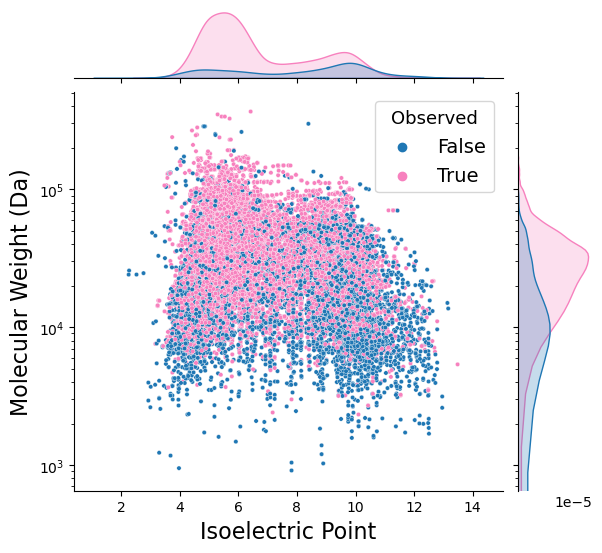

In [ ]:
# plot the isoelectric point vs molecular weight, add marginal distributions, log scale on molecular weight
g = sns.jointplot(data=proteoform_predictions, x="isoelectric_point", y="protein_weight", hue="observed", kind="scatter", palette = {False: "#1F77B4", True : "#F781BE"}, s=10)
g.ax_joint.set_yscale('log')
plt.subplots_adjust(top=0.9)
plt.xlabel("Isoelectric Point", fontsize=16)
plt.ylabel("Molecular Weight (Da)", fontsize=16)
plt.legend(fontsize=14, title="Observed", title_fontsize='13', loc='upper right')

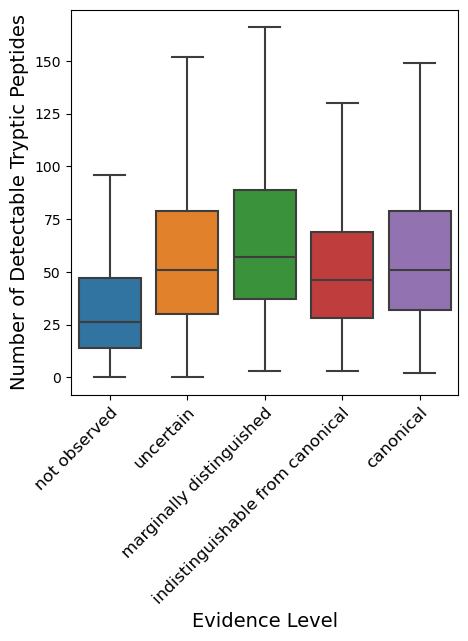

In [ ]:
# color by evidence level
plt.figure(figsize=(5, 5))

# fix order of evidence levels
evidence_order = ["not observed", "uncertain", "marginally_distinguished", "indistinguishable_from_canonical", "canonical"]
sns.boxplot(data=proteoform_predictions, y="detectable_tryptic_peptides", x="evidence_level", showfliers=False, order=evidence_order)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xticks(ticks=np.arange(len(evidence_order)), labels=[key.replace("_", " ") for key in evidence_order], fontsize=12)
plt.xlabel("Evidence Level", fontsize=14)
plt.ylabel("Number of Detectable Tryptic Peptides", fontsize=14)

plt.show()

Text(0, 0.5, 'Proteoform count')

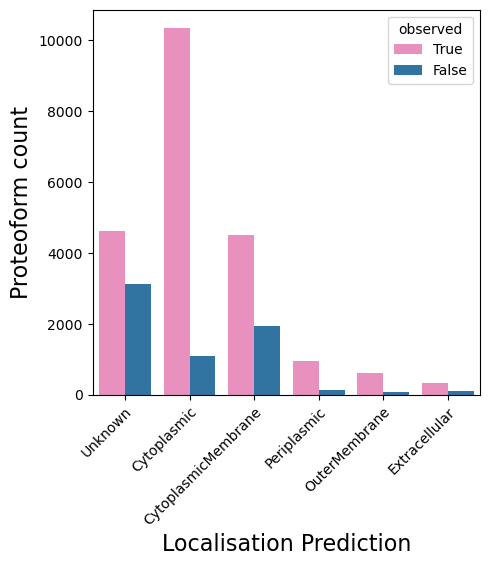

In [ ]:
# bar chart per localisation: how many observed vs how many unobserved?
plt.figure(figsize=(5, 5))
sns.countplot(data=proteoform_predictions.astype({"observed": str}), x="PSORTb_Prediction", hue="observed", palette={"True": "#F781BE", "False": "#1F77B4"})
plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
plt.xlabel("Localisation Prediction", fontsize=16)
plt.ylabel("Proteoform count", fontsize=16)